# Executando script para visualizar imagens do banco de dados NOAA-GOES-16
#### Script by Hamed Alemohammad.
#####Acess in https://github.com/HamedAlemo/visualize-goes16/blob/main/visualize_GOES16_from_AWS.ipynb

In [3]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.8 MB/s eta 0:00:00


In [5]:
pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.8 MB/s eta 0:00:00


In [6]:
import xarray as xr
import requests
import netCDF4
import boto3
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

In [9]:
# Inicialiizando s3 client.

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Definindo parâmetros

bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-CMIPF'
year = 2020
day_of_year = 183
hour = 14
band = 3

In [8]:
# Função para obter objetos dentro do s3 client

def get_s3_keys(bucket, s3_client, prefix=''):

    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):

        kwargs['Prefix'] = prefix

    while True:

        resp = s3_client.list_objects_v2(**kwargs)

        # Check if 'Contents' key exists before accessing

        if 'Contents' in resp:

            for obj in resp['Contents']:

                key = obj['Key']

                if key.startswith(prefix):

                    yield key
        else:
            # If no 'Contents', it means no objects found for the prefix

            print(f"No objects found for prefix: {prefix}")

            break  # Exit the loop

        try:

            kwargs['ContinuationToken'] = resp['NextContinuationToken']

        except KeyError:

            break

In [10]:
# Função para obter o arquivo

def get_key():

  keys = get_s3_keys(bucket_name,
                    s3_client,
                    prefix=f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'
                    )

  # Get a list of keys instead of the generator

  key_list = list(keys)

  # Check if any keys were found before accessing the first one

  if key_list:

      key = key_list[0]  # selecting the first measurement taken within the hour

  else:

      print("Não há chaves encontradas com o prefixo especificado.")

  return key

In [13]:
# Acessando arquivos NC

def net_cdf():

  # Baixando arquivo

  resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{get_key()}')

  # Extraindo o nome do arquivo

  file_name = get_key().split('/')[-1].split('.')[0]

  # Abrindo arquivo NetCDF4

  nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)

  # Abrindo arquivo NetCDF4

  store = xr.backends.NetCDF4DataStore(nc4_ds)

  DS = xr.open_dataset(store)

  return file_name, DS

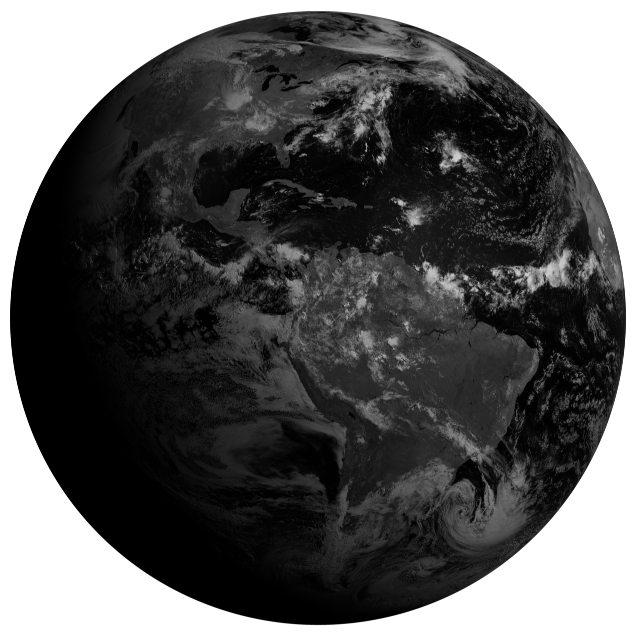

In [16]:
# Função para exibição de imagem

def show():

  fig = plt.figure(figsize=(8, 8))

  # The variable might be named differently, checking the available variables:

  #print(DS.variables)  Print available variables to find the correct name

  # Assuming the variable is named 'CMI', replace 'DS.Rad' with 'DS.CMI'

  plt.imshow(net_cdf()[1].CMI, cmap='gray')

  plt.axis('off')

  plt.savefig(f'{net_cdf()[0]}.png', dpi=300, facecolor='w', edgecolor='w')

show()